In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob 
#from astropy.visualization import quantity_support
#quantity_support()  # for getting units on the axes below  
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from termcolor import colored 
from astropy import units as u
from astropy import constants as const
import pandas as pd
import warnings
from astropy import stats as st

In [2]:
#grab anything that contains '.fits'
files = glob('*.fits')
mcfiles = glob('*emcee.h5')

# sort mcfiles to the order files is in
mcfiles_sorted = [] # create empty list
# iterate through each value in files and if they start the same add it to the 
# new list so that mcfiles is ordered the same as files
for j in range(len(files)): 
    for i in range(len(mcfiles)):
        mcfilehead=mcfiles[i][:-9]
        if files[j]==mcfilehead:
            mcfiles_sorted.append(mcfiles[i])

In [3]:
df = pd.read_csv('/Users/kchen/Downloads/ysg.csv') # read csv

In [4]:
def fitsfile(i):
    """
    Opens fits file and prints which file it is
    """
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]

    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('This graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    print(text)  
    #print(specdata)
    
    #print(spec1d)
    return spec1d
    

In [5]:
def smooth(i):
    """
    Smooths the data for graph i so that it is easier to see the continuum and match the model to the data.
    """
    spec1d = fitsfile(i)
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    #print(spec_interp)
    return spec_interp, spec1d

In [6]:
def loademcee(i):
    """
    reads the h5 file and generates theta values where theta is [t_eff, log_g, rv, ebv, radius]
    """
    # load the file
    reader = emcee.backends.HDFBackend('/Users/kchen/FYPS/' + mcfiles_sorted[i], name='rv_prior')
    #discard first 1000 points where it's converging
    samples = reader.get_chain(flat=True, discard=1000)
    return samples

In [7]:
def ssp(theta):
    """
    plots a stsynphot graph based on a theta that holds the values of t_eff, log_g, rv, ebv, radius
    """
    t_eff, log_g, rv, ebv, radius = theta # unpack theta
    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) # model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) # speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) # average of total/selective dimming
    
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2
    
    return reddenedmodel_flux

In [8]:
def binary(wavelength, i):
    """
    Takes an array of wavelength points and graph number i and 
    outputs 
    """
    # unpack values from smoothed data and loademcee
    spec_interp, spec1d = smooth(i)
    samples = loademcee(i) # unpack

    
    # calculate the graph from emcee median
    teff=np.percentile(samples[:,0], [50])
    logg=np.percentile(samples[:,1], [50])
    rv=np.percentile(samples[:,2], [50])[0]
    ebv=np.percentile(samples[:,3], [50])[0]
    rad=np.percentile(samples[:,4], [50])
    
    theta = [teff, logg, rv, ebv, rad]
    reddenedmodel_flux = ssp(theta)


    y_value = (spec_interp.flux.value-reddenedmodel_flux.value)/reddenedmodel_flux.value

    ax = plt.subplots()[1]
    ax.plot(wavelength, y_value, alpha=1, color='black')
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)
    
    plt.show()



This graph is: j05344_122722.fits and array 20


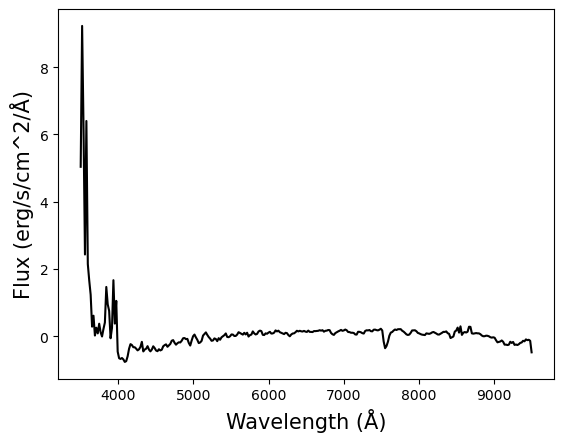

In [10]:
wavelength = np.linspace(3500, 9500, 318)
# for i in range(len(mcfiles_sorted)):
#     warnings.filterwarnings('ignore')
#     binary(wavelength, i)
binary(wavelength, 20)

This graph is: hd269857_122722.fits and array 1


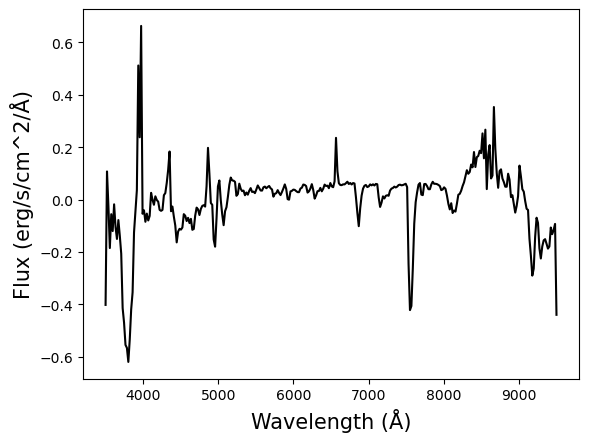

This graph is: hd269723_122722.fits and array 3


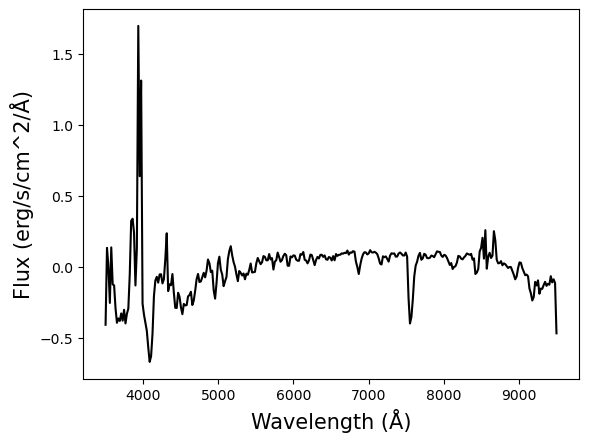

This graph is: hd269697_122722.fits and array 7


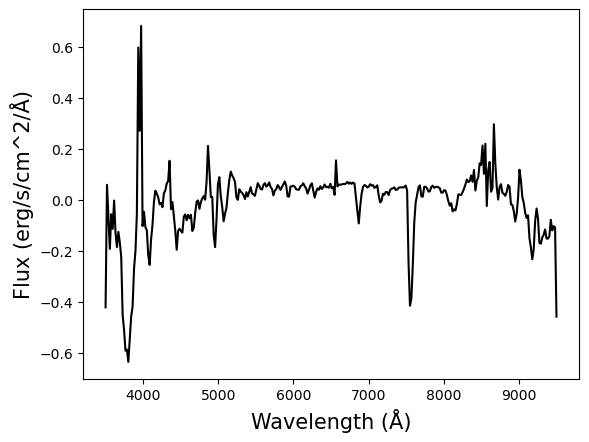

This graph is: hd269331_122622.fits and array 10


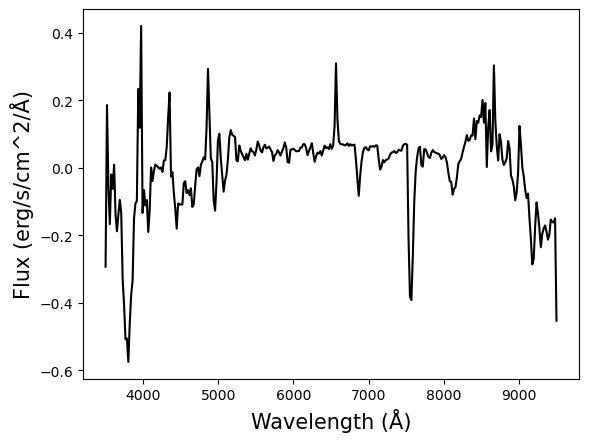

This graph is: hd269953_122722.fits and array 14


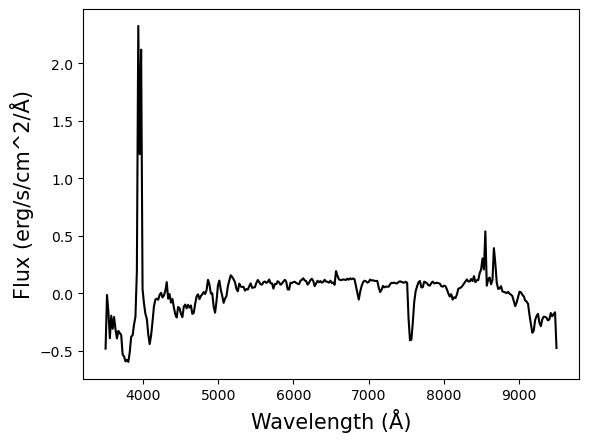

This graph is: hd268819_122622.fits and array 19


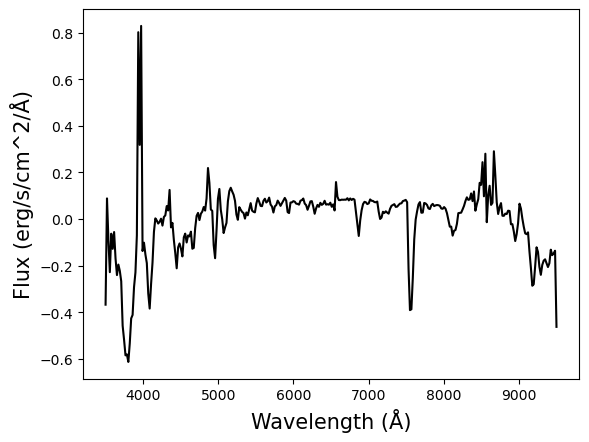

This graph is: cd_69_310_122622.fits and array 21


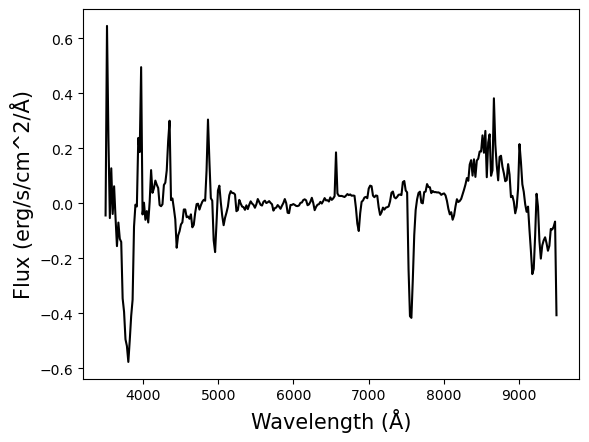

This graph is: cpd-69-496_122722.fits and array 23


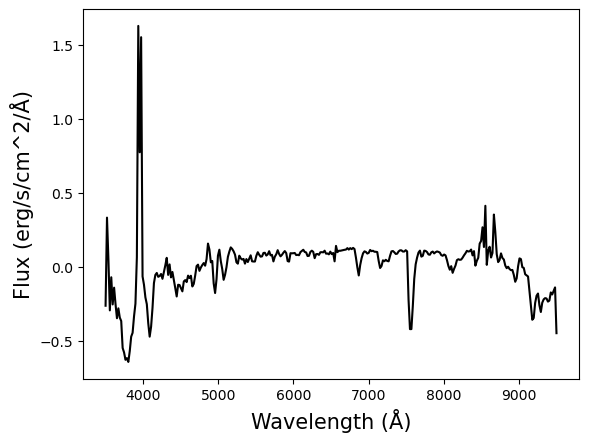

This graph is: hd268687_122622.fits and array 24


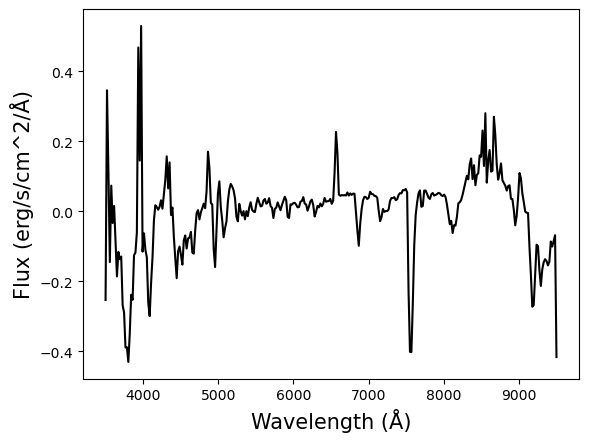

This graph is: hd269982_122722.fits and array 28


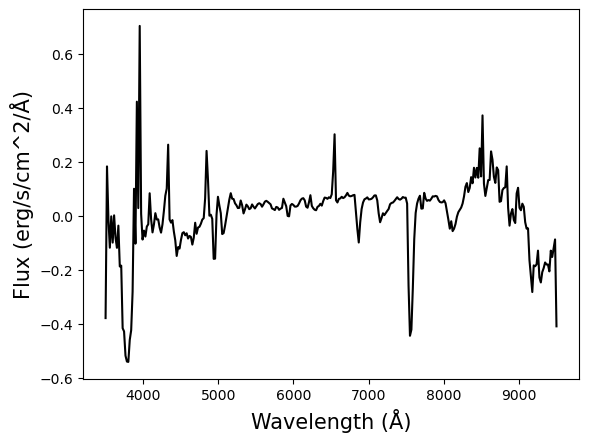

This graph is: hd268949_010323.fits and array 30


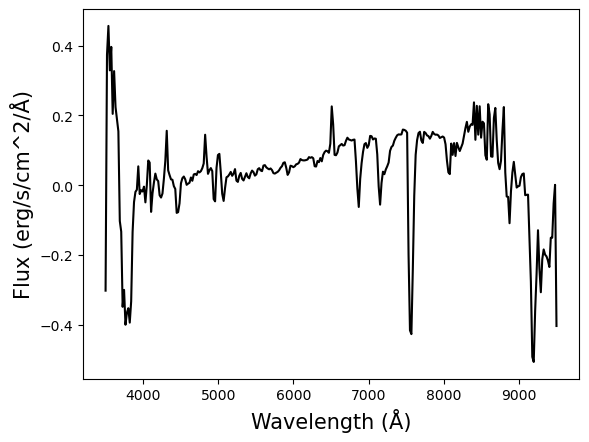

This graph is: hd268946_122622.fits and array 31


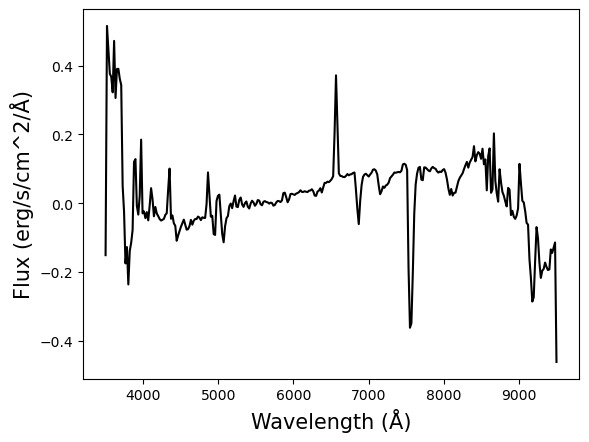

This graph is: hd269840_122722.fits and array 32


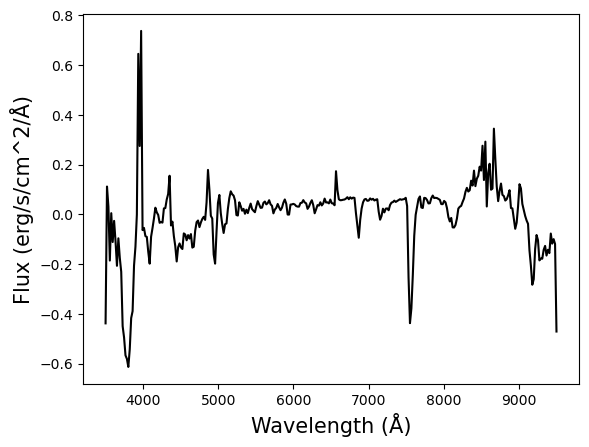

This graph is: hd269787_122722.fits and array 35


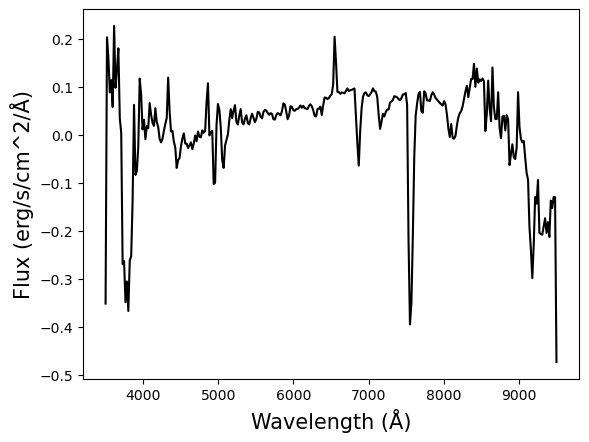

This graph is: hd268971_122622.fits and array 37


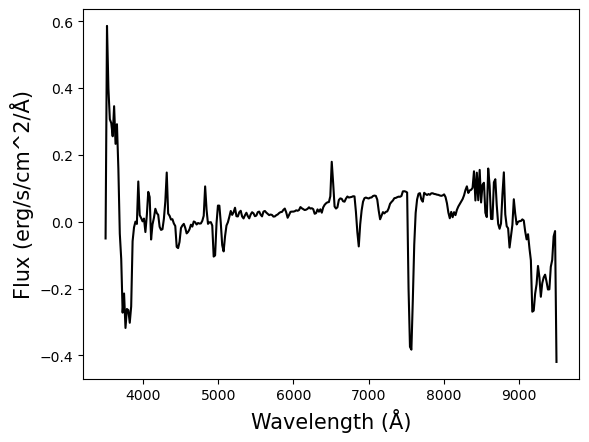

In [97]:
# list for if it has binary
has_binary = [0,2,4,5,6,9,11,16,17,18,20,22,25,26,27,29,33,34,36,38]
# list for maybe binary
maybe_binary = [1,3,7,10,14,19,21,23,24,28,30,31,32,35,37]
for i in range(len(mcfiles_sorted)):
    warnings.filterwarnings('ignore')
    if i in maybe_binary:
        binary(wavelength, i)

In [92]:
def hilowres(i):#t_eff, log_g, rv, ebv, radius, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)--emitted vs observed Flux fobs=fsurface(R/d)^2, multiply reddening by (r/d)^2. R in solar radii. d=158200 lightyear 
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    spec_interp, spec1d = smooth(i)

    ax = plt.subplots()[1]
    
    ax.plot(spec1d.spectral_axis.value, spec1d.flux.value, alpha = .4)
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value)


    
    
    
    
    ax.set_xlim(3250,3700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize=15)
    ax.set_xlabel('Wavelength (Å)', fontsize=15)
    #plt.plot(wavelength, reddenedmodel_flux)
    plt.show()


This graph is: hd33579_122622.fits and array 15


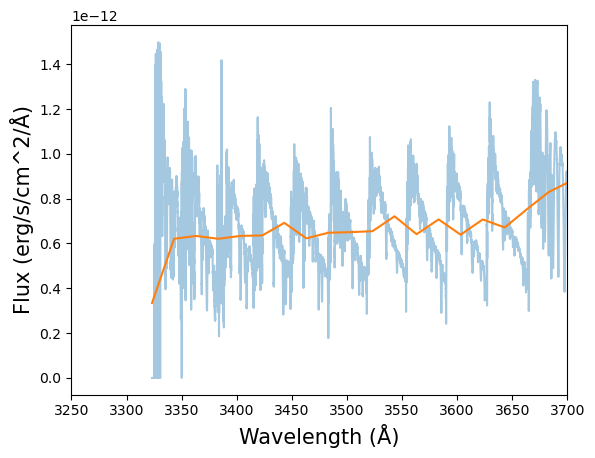

In [103]:
hilowres(15
        )

In [76]:
# function to determine if the graph has emission line at 6562.8 A
binary_list= [4,6,9,11,16,17,18,20,22,25,27,29,33,37,38]
for i in range(len(mcfiles)):
    if i in binary_list:
        hilowres(i)


This graph is: hd269902_122722.fits and array 8


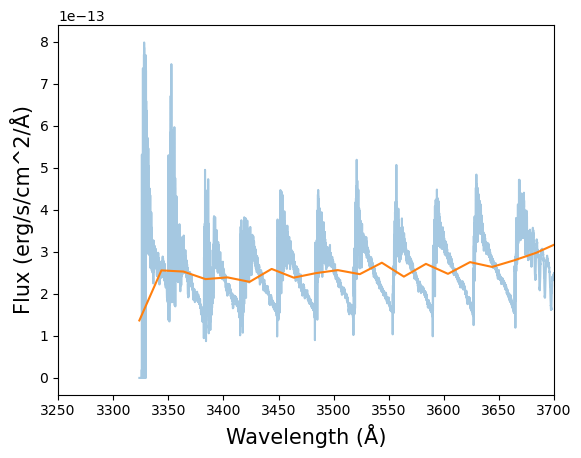

This graph is: hd268727_010323.fits and array 12


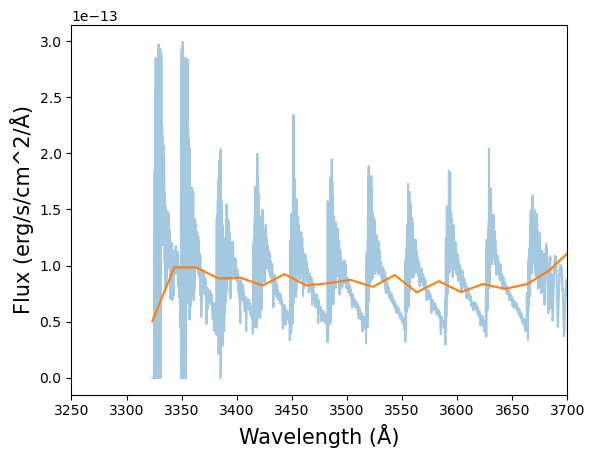

This graph is: hd269762_122722.fits and array 13


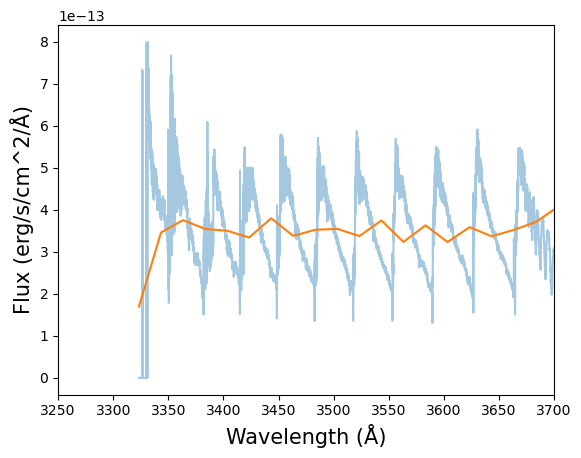

This graph is: hd33579_122622.fits and array 15


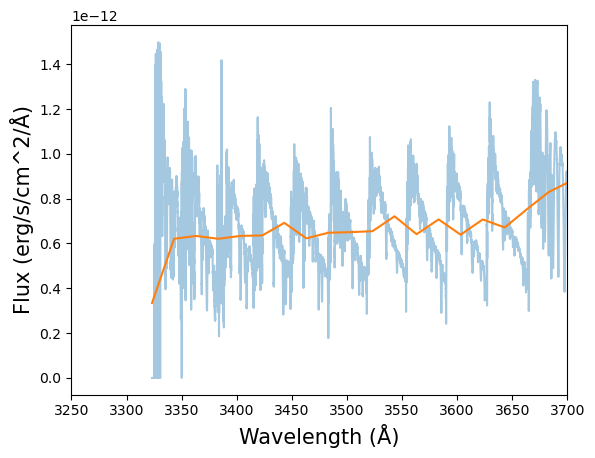

In [110]:
# list for if it has binary
has_binary = [0,2,4,6,9,11,16,17,18,20,22,25,26,27,29,30,33,34,36,38]
# list for maybe binary
maybe_binary = [1,3,5,7,10,14,19,21,23,24,28,31,32,35,37]
for i in range(len(mcfiles)):
    if (i not in maybe_binary) and (i not in has_binary):
        hilowres(i)


In [112]:
len(has_binary
   )

20

This graph is: j05344_122722.fits and array 20


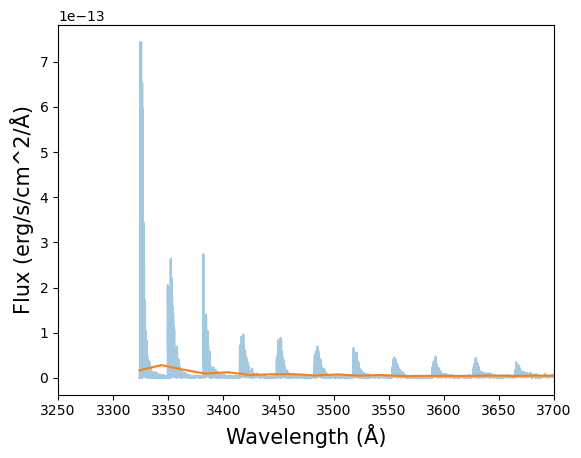

In [136]:
hilowres(20)

In [125]:
# halpha/total
bincon_halpha = st.binom_conf_interval(28, 39)
middle =((bincon[1]-bincon[0])/2)+bincon[0]
diff = (bincon[1]-bincon[0])/2
print(middle, diff)

0.7124999888497899 0.07135935760066203


In [146]:
# binary confirmed/total
bincon_bin = st.binom_conf_interval(20, 39)
middle = ((bincon_bin[1]-bincon_bin[0])/2)+bincon_bin[0]
diff = (bincon_bin[1]-bincon_bin[0])/2
print(middle, diff)

0.5124999993441053 0.07903167954499024


In [128]:
# FYPS/total 13/39
bincon_fyps = st.binom_conf_interval(13, 39)
middle = ((bincon_fyps[1]-bincon_fyps[0])/2)+bincon_fyps[0]
diff = (bincon_fyps[1]-bincon_fyps[0])/2
print(middle, diff)

0.33750000852663126 0.07465204690136562


In [129]:
# (FYPS halpha)/halpha 13/28
bincon_fypshalpha = st.binom_conf_interval(13, 28)
middle = ((bincon_fypshalpha[1]-bincon_fypshalpha[0])/2)+bincon_fypshalpha[0]
diff = (bincon_fypshalpha[1]-bincon_fypshalpha[0])/2
print(middle, diff)

0.4655172438749858 0.09261879177798021


In [145]:
# (FYPS binary confirmed)/binary confirmed 4/20
count=0
for i in range(39):
    if (df.loc[i, 'FYPS'] == True) and (df.loc[i, 'binary'] == 1):
        count+=1
bincon_fypsbin = st.binom_conf_interval(count, 20)
middle = ((bincon_fypsbin[1]-bincon_fypsbin[0])/2)+bincon_fypsbin[0]
diff = (bincon_fypsbin[1]-bincon_fypsbin[0])/2
print(middle, diff)

0.21428574284167323 0.08844854604475305


In [144]:
# (binary confirmed halpha)/halpha
count1=0
for i in range(39):
    if (df.loc[i, 'halpha_emission'] == True) and (df.loc[i, 'binary'] == 1):
        count1+=1
bincon_binhalpha = st.binom_conf_interval(count1, 28)
middle = ((bincon_binhalpha[1]-bincon_binhalpha[0])/2)+bincon_binhalpha[0]
diff = (bincon_binhalpha[1]-bincon_binhalpha[0])/2
print(middle, diff)

0.43103448774997155 0.09192845580640466


In [181]:
# use latex for axis
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
def binconf():
    """
    binomial confidence interval graph
    """
    fig, ax = plt.subplots(dpi=300)
    # halpha/total 28/39
    bincon_halpha = st.binom_conf_interval(28, 39)
    middle_halpha = ((bincon_halpha[1]-bincon_halpha[0])/2)+bincon_halpha[0]
    diff_halpha = (bincon_halpha[1]-bincon_halpha[0])/2
    ax.errorbar(1, middle_halpha, yerr=diff_halpha, color='tab:blue', fmt='o')
    # binary confirmed/total 20/39
    bincon_bin = st.binom_conf_interval(20, 39)
    middle_bin = ((bincon_bin[1]-bincon_bin[0])/2)+bincon_bin[0]
    diff_bin = (bincon_bin[1]-bincon_bin[0])/2
    ax.errorbar(2, middle_bin, yerr=diff_bin, color='tab:blue', fmt='o')
    
    # FYPS/total 13/39
    bincon_fyps = st.binom_conf_interval(13, 39)
    middle_fyps = ((bincon_fyps[1]-bincon_fyps[0])/2)+bincon_fyps[0]
    diff_fyps = (bincon_fyps[1]-bincon_fyps[0])/2
    ax.errorbar(3, middle_fyps, yerr=diff_fyps, color='tab:blue', fmt='o')
    
    # (FYPS halpha)/halpha 13/28
    bincon_fypshalpha = st.binom_conf_interval(13, 28)
    middle_fypshalpha = ((bincon_fypshalpha[1]-bincon_fypshalpha[0])/2)+bincon_fypshalpha[0]
    diff_fypshalpha = (bincon_fypshalpha[1]-bincon_fypshalpha[0])/2
    ax.errorbar(4, middle_fypshalpha, yerr=diff_fypshalpha, color='tab:blue', fmt='o')
    
    # (FYPS binary confirmed)/binary confirmed 4/20
    count=0
    for i in range(39):
        if (df.loc[i, 'FYPS'] == True) and (df.loc[i, 'binary'] == 1):
            count+=1
    bincon_fypsbin = st.binom_conf_interval(count, 20)
    middle_fypsbin = ((bincon_fypsbin[1]-bincon_fypsbin[0])/2)+bincon_fypsbin[0]
    diff_fypsbin = (bincon_fypsbin[1]-bincon_fypsbin[0])/2
    ax.errorbar(5, middle_fypsbin, yerr=diff_fypsbin, color='tab:blue', fmt='o')
    
    # (binary confirmed halpha)/halpha
    count1=0
    for i in range(39):
        if (df.loc[i, 'halpha_emission'] == True) and (df.loc[i, 'binary'] == 1):
            count1+=1
    bincon_binhalpha = st.binom_conf_interval(count1, 28)
    middle_binhalpha = ((bincon_binhalpha[1]-bincon_binhalpha[0])/2)+bincon_binhalpha[0]
    diff_binhalpha = (bincon_binhalpha[1]-bincon_binhalpha[0])/2
    ax.errorbar(6, middle_binhalpha, yerr=diff_binhalpha, color='tab:blue', fmt='o')
    
    # fyps bin confirmed / fyps
    bincon_binfyps = st.binom_conf_interval(count, 13)
    middle_binfyps = ((bincon_binfyps[1]-bincon_binfyps[0])/2)+bincon_binfyps[0]
    diff_binfyps = (bincon_binfyps[1]-bincon_binfyps[0])/2
    ax.errorbar(7, middle_binfyps, yerr=diff_binfyps, color='tab:blue', fmt='o')
    
    #halpha fyps / fyps 13/13
    bincon_halphafyps = st.binom_conf_interval(13, 13)
    middle_halphafyps = ((bincon_halphafyps[1]-bincon_halphafyps[0])/2)+bincon_halphafyps[0]
    diff_halphafyps = (bincon_halphafyps[1]-bincon_halphafyps[0])/2
    ax.errorbar(8, middle_halphafyps, yerr=diff_halphafyps, color='tab:blue', fmt='o')
    
    x = ['', r'$p(H\alpha)$', 'bin/total', 'fyps/total', 'halphafyps/halpha', 'binfyps/bin', 'binhalpha/halpha', 'fypsbin/fyps', r'$p(H\alpha | {\rm FYPS})$']
    default_x_ticks = range(len(x))

    ax.set_xticks(default_x_ticks, x, rotation = (45), fontsize = 10)

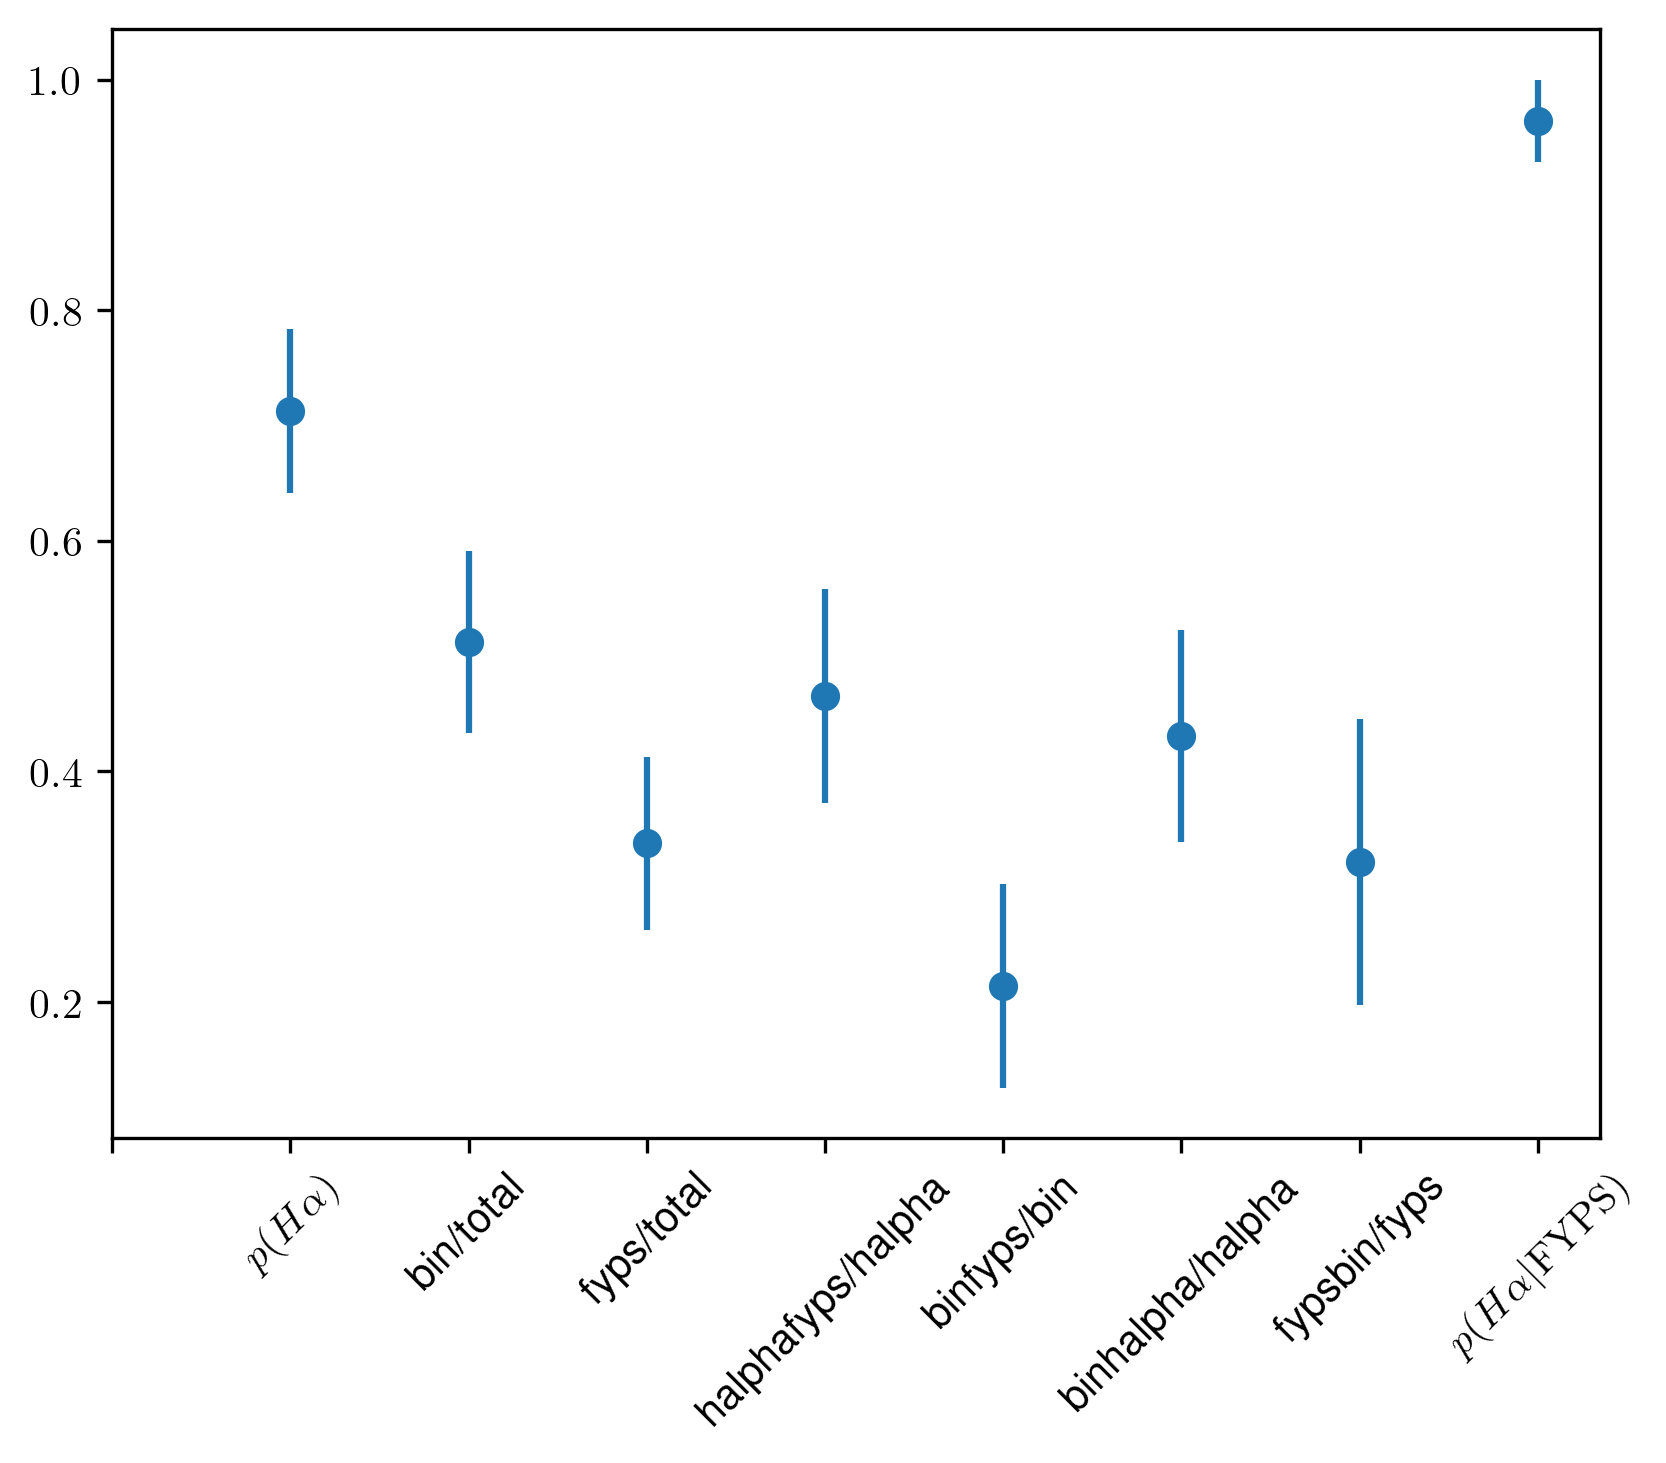

In [182]:
binconf()

In [187]:

def binconfcond():
    """
    condensed binomial confidence interval graph
    """
    fig, ax = plt.subplots(dpi=300)
    # halpha/total 28/39
    bincon_halpha = st.binom_conf_interval(28, 39)
    middle_halpha = ((bincon_halpha[1]-bincon_halpha[0])/2)+bincon_halpha[0]
    diff_halpha = (bincon_halpha[1]-bincon_halpha[0])/2
    ax.errorbar(1, middle_halpha, yerr=diff_halpha, color='tab:blue', fmt='o')
    # binary confirmed/total 20/39
    bincon_bin = st.binom_conf_interval(20, 39)
    middle_bin = ((bincon_bin[1]-bincon_bin[0])/2)+bincon_bin[0]
    diff_bin = (bincon_bin[1]-bincon_bin[0])/2
    ax.errorbar(2, middle_bin, yerr=diff_bin, color='tab:blue', fmt='o')
    
    # (FYPS binary confirmed)/binary confirmed 4/20
    count=0
    for i in range(39):
        if (df.loc[i, 'FYPS'] == True) and (df.loc[i, 'binary'] == 1):
            count+=1
    
    # fyps bin confirmed / fyps
    bincon_binfyps = st.binom_conf_interval(count, 13)
    middle_binfyps = ((bincon_binfyps[1]-bincon_binfyps[0])/2)+bincon_binfyps[0]
    diff_binfyps = (bincon_binfyps[1]-bincon_binfyps[0])/2
    ax.errorbar(3, middle_binfyps, yerr=diff_binfyps, color='tab:blue', fmt='o')
    
    #halpha fyps / fyps 13/13
    bincon_halphafyps = st.binom_conf_interval(13, 13)
    middle_halphafyps = ((bincon_halphafyps[1]-bincon_halphafyps[0])/2)+bincon_halphafyps[0]
    diff_halphafyps = (bincon_halphafyps[1]-bincon_halphafyps[0])/2
    ax.errorbar(4, middle_halphafyps, yerr=diff_halphafyps, color='tab:blue', fmt='o')
    
    x = ['', r'$p(H\alpha)$', r'$p(\rm binary)$', r'$p(\rm binary | {\rm FYPS})$', r'$p(H\alpha | {\rm FYPS})$']
    default_x_ticks = range(len(x))

    ax.set_xticks(default_x_ticks, x, rotation = (45), fontsize = 10)

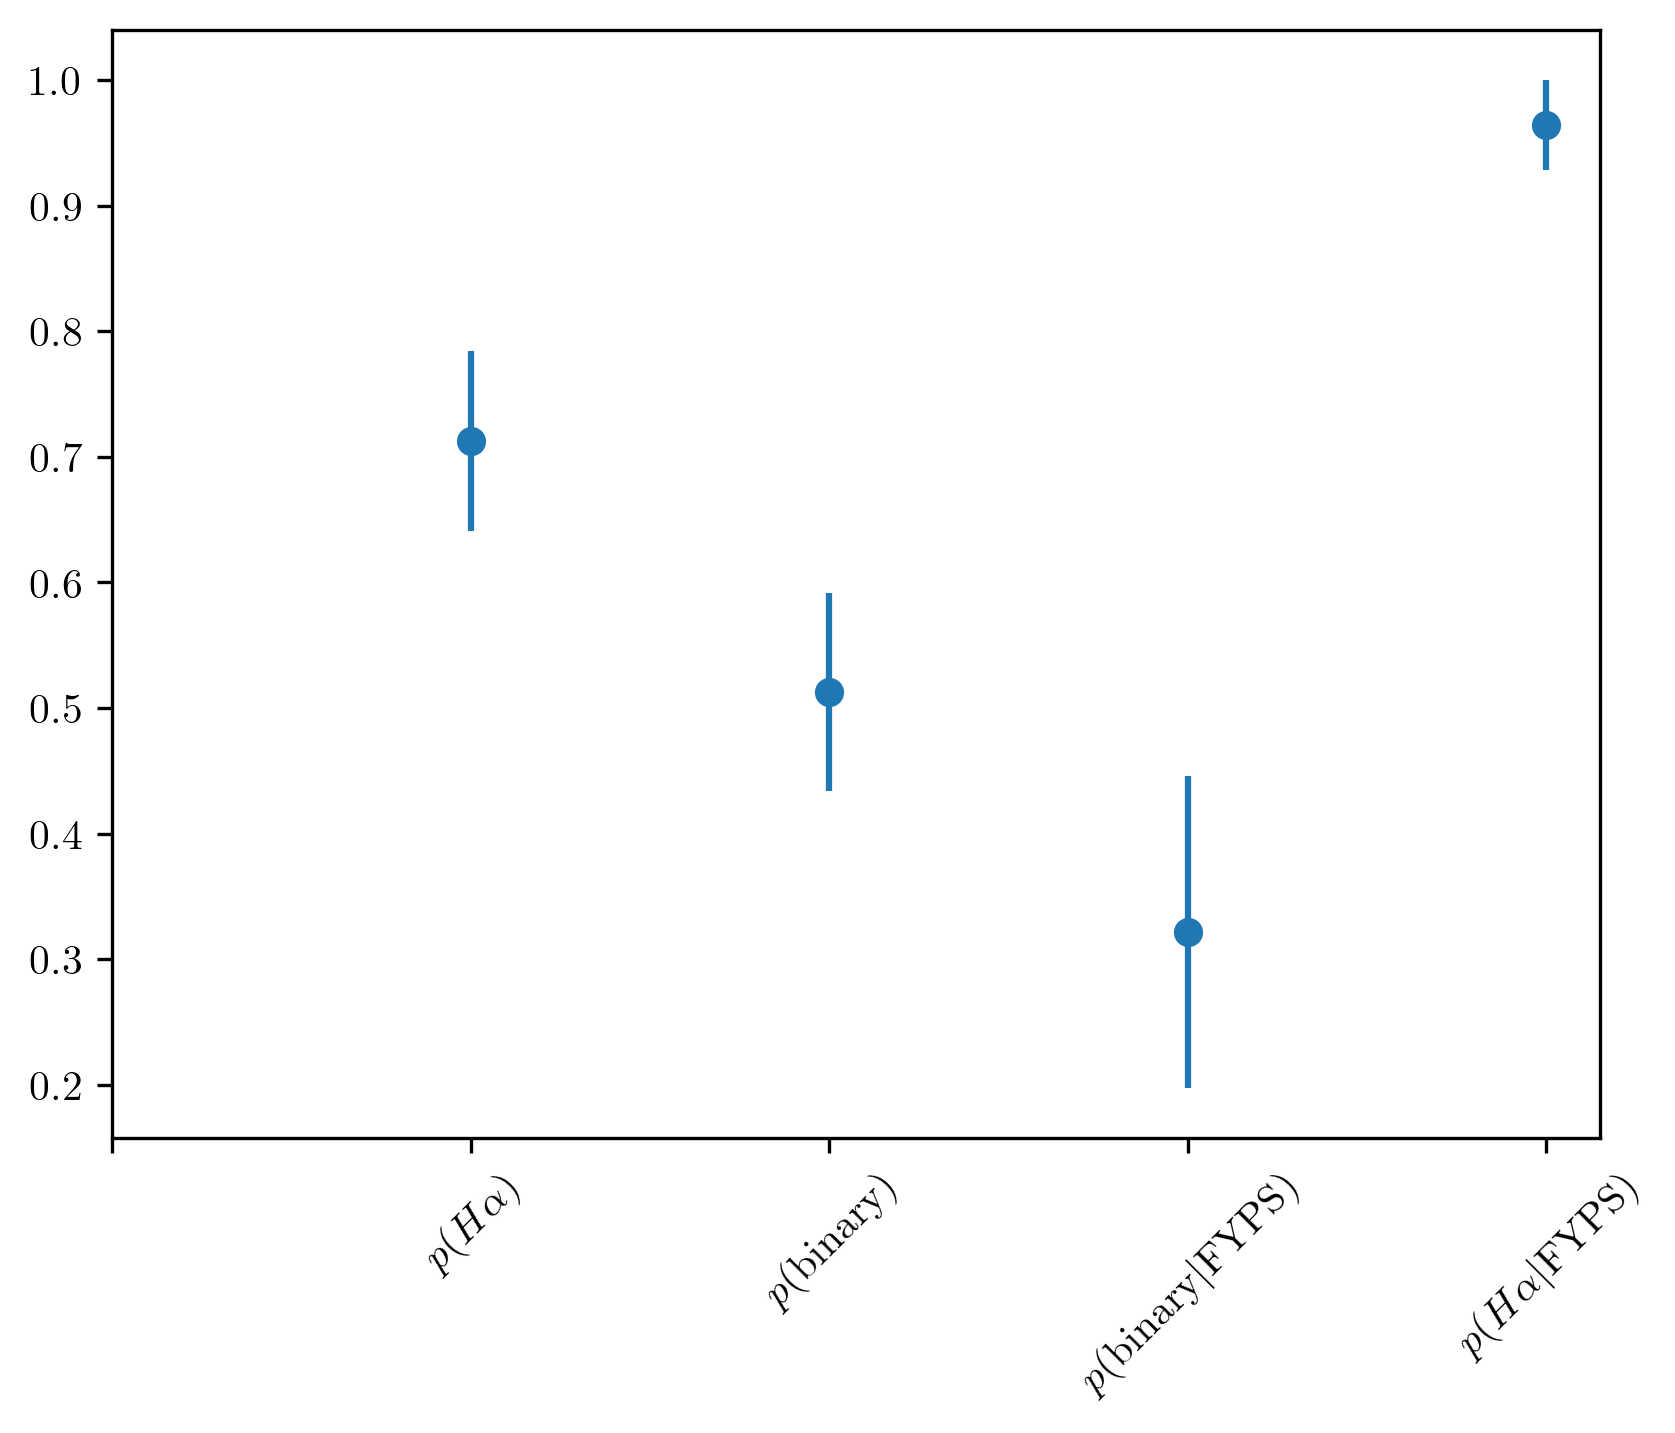

In [188]:
binconfcond()